BTC

In [97]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/DataBA/BTC.csv')
df1=df.reset_index()['Close']


In [99]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [100]:
# Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]


In [101]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [102]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [103]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [104]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [105]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
27/27 [==============================] - 2s 20ms/step - loss: 0.0061
Epoch 2/100
27/27 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 8.5902e-04
Epoch 4/100
27/27 [==============================] - 1s 20ms/step - loss: 7.5500e-04
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 7.2234e-04
Epoch 6/100
27/27 [==============================] - 1s 21ms/step - loss: 6.3432e-04
Epoch 7/100
27/27 [==============================] - 1s 36ms/step - loss: 6.1715e-04
Epoch 8/100
27/27 [==============================] - 1s 36ms/step - loss: 5.8125e-04
Epoch 9/100
27/27 [==============================] - 1s 36ms/step - loss: 5.1879e-04
Epoch 10/100
27/27 [==============================] - 1s 36ms/step - loss: 5.7097e-04
Epoch 11/100
27/27 [==============================] - 1s 39ms/step - loss: 4.8249e-04
Epoch 12/100
27/27 [==============================] - 1s 36ms/step - lo

In [106]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 15ms/step


In [107]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [108]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
import math
from sklearn.metrics import mean_squared_error

# Hàm tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm tính MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính MASE
def mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính sai số tuyệt đối trung bình của mô hình
    mae = np.mean(np.abs(y_true - y_pred))

    # Tính sai số tuyệt đối trung bình của phương pháp đơn giản (naive forecast)
    naive_forecast_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))

    if naive_forecast_error == 0:
        return np.inf
    else:
        return mae / naive_forecast_error

rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)
mase_value = mase(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_value)
print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Scaled Error (MASE):", mase_value)

Root Mean Squared Error (RMSE): 66107.55124331948
Mean Absolute Percentage Error (MAPE): 7283342.707613545
Mean Absolute Scaled Error (MASE): 3222503.673438172


In [109]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.8976571]
101
1 day input [0.94063252 0.98574693 0.97684399 1.         0.97624905 0.94898831
 0.88807934 0.93633355 0.92286924 0.84065993 0.92491314 0.89080009
 0.86341985 0.87303752 0.91620228 0.95429367 0.95656008 0.94895488
 0.96578137 0.95355527 0.95103407 0.97315874 0.95184435 0.89040098
 0.89937896 0.93362428 0.92598551 0.93998867 0.94693049 0.97910939
 0.94419726 0.96306793 0.95730722 0.91564823 0.87329446 0.89233197
 0.86240528 0.86502877 0.83103107 0.86127323 0.86913421 0.88193157
 0.88248935 0.91006298 0.90386142 0.87379844 0.87672793 0.86684284
 0.86220759 0.85612654 0.86701127 0.82316908 0.78736232 0.7998214
 0.85240686 0.86790173 0.87019726 0.85810545 0.84638807 0.82974106
 0.85685475 0.82497669 0.82348885 0.834474   0.85408838 0.83522373
 0.90186745 0.88755499 0.91271918 0.91143577 0.90329388 0.97604505
 0.95719748 0.94458131 0.92591665 0.93468188 0.94515516 0.93493509
 0.94775511 0.93270913 0.92220903 0.93240126 0.92092763 0.92339144
 0.92387232 0.93860914 0.96429309 0

In [110]:
# Dự báo 60 ngày tiếp theo

x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.8976571]
101
1 day input [0.94063252 0.98574693 0.97684399 1.         0.97624905 0.94898831
 0.88807934 0.93633355 0.92286924 0.84065993 0.92491314 0.89080009
 0.86341985 0.87303752 0.91620228 0.95429367 0.95656008 0.94895488
 0.96578137 0.95355527 0.95103407 0.97315874 0.95184435 0.89040098
 0.89937896 0.93362428 0.92598551 0.93998867 0.94693049 0.97910939
 0.94419726 0.96306793 0.95730722 0.91564823 0.87329446 0.89233197
 0.86240528 0.86502877 0.83103107 0.86127323 0.86913421 0.88193157
 0.88248935 0.91006298 0.90386142 0.87379844 0.87672793 0.86684284
 0.86220759 0.85612654 0.86701127 0.82316908 0.78736232 0.7998214
 0.85240686 0.86790173 0.87019726 0.85810545 0.84638807 0.82974106
 0.85685475 0.82497669 0.82348885 0.834474   0.85408838 0.83522373
 0.90186745 0.88755499 0.91271918 0.91143577 0.90329388 0.97604505
 0.95719748 0.94458131 0.92591665 0.93468188 0.94515516 0.93493509
 0.94775511 0.93270913 0.92220903 0.93240126 0.92092763 0.92339144
 0.92387232 0.93860914 0.96429309 0

In [111]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1



[0.8976571]
101
1 day input [0.94063252 0.98574693 0.97684399 1.         0.97624905 0.94898831
 0.88807934 0.93633355 0.92286924 0.84065993 0.92491314 0.89080009
 0.86341985 0.87303752 0.91620228 0.95429367 0.95656008 0.94895488
 0.96578137 0.95355527 0.95103407 0.97315874 0.95184435 0.89040098
 0.89937896 0.93362428 0.92598551 0.93998867 0.94693049 0.97910939
 0.94419726 0.96306793 0.95730722 0.91564823 0.87329446 0.89233197
 0.86240528 0.86502877 0.83103107 0.86127323 0.86913421 0.88193157
 0.88248935 0.91006298 0.90386142 0.87379844 0.87672793 0.86684284
 0.86220759 0.85612654 0.86701127 0.82316908 0.78736232 0.7998214
 0.85240686 0.86790173 0.87019726 0.85810545 0.84638807 0.82974106
 0.85685475 0.82497669 0.82348885 0.834474   0.85408838 0.83522373
 0.90186745 0.88755499 0.91271918 0.91143577 0.90329388 0.97604505
 0.95719748 0.94458131 0.92591665 0.93468188 0.94515516 0.93493509
 0.94775511 0.93270913 0.92220903 0.93240126 0.92092763 0.92339144
 0.92387232 0.93860914 0.96429309 0

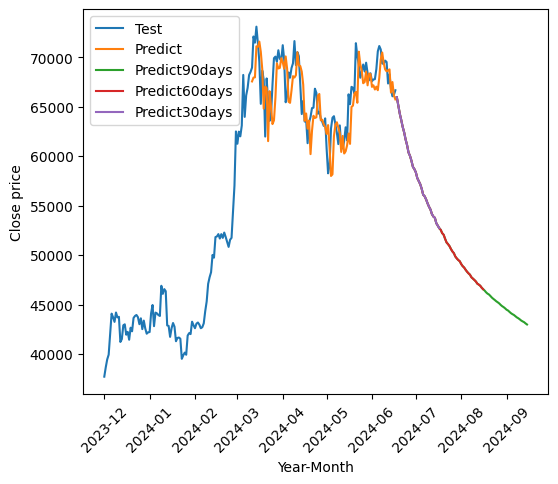

In [112]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Create the figure

# Assuming 'df' has a 'Date' column and 'train_size' is defined
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df['Date'][train_size+101:], y_pred, label='Predict')

# Generate future dates for predictions
predict_data_index_90 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=90, freq='D'
)
predict_data_index_60 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=60, freq='D'
)
predict_data_index_30 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=30, freq='D'
)

# Plot predictions (assuming lst_output_90, lst_output_60, lst_output_30 are predictions)
plt.plot(predict_data_index_90, scaler.inverse_transform(lst_output_90), label='Predict90days')
plt.plot(predict_data_index_60, scaler.inverse_transform(lst_output_60), label='Predict60days')
plt.plot(predict_data_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Year-Month')
plt.ylabel('Close price')
plt.legend()  # Use legend() to automatically generate labels from label arguments in plot

plt.show()


ETH

In [113]:
# Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
# Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/DataBA/ETH.csv')
df1=df.reset_index()['Close']


In [115]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [116]:
# Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [117]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [118]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [119]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [120]:
# Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [121]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
27/27 [==============================] - 2s 20ms/step - loss: 0.0017
Epoch 2/100
27/27 [==============================] - 1s 20ms/step - loss: 6.2923e-04
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 4.9329e-04
Epoch 4/100
27/27 [==============================] - 1s 20ms/step - loss: 4.1887e-04
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 3.9577e-04
Epoch 6/100
27/27 [==============================] - 1s 20ms/step - loss: 3.7160e-04
Epoch 7/100
27/27 [==============================] - 1s 33ms/step - loss: 3.7257e-04
Epoch 8/100
27/27 [==============================] - 1s 35ms/step - loss: 3.6363e-04
Epoch 9/100
27/27 [==============================] - 1s 34ms/step - loss: 3.6716e-04
Epoch 10/100
27/27 [==============================] - 1s 35ms/step - loss: 3.3785e-04
Epoch 11/100
27/27 [==============================] - 1s 37ms/step - loss: 3.5690e-04
Epoch 12/100
27/27 [==============================] - 1s 37ms/step 

In [122]:
# Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 7ms/step


In [123]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [124]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
import math
from sklearn.metrics import mean_squared_error

# Hàm tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm tính MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính MASE
def mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính sai số tuyệt đối trung bình của mô hình
    mae = np.mean(np.abs(y_true - y_pred))

    # Tính sai số tuyệt đối trung bình của phương pháp đơn giản (naive forecast)
    naive_forecast_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))

    if naive_forecast_error == 0:
        return np.inf
    else:
        return mae / naive_forecast_error

rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)
mase_value = mase(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_value)
print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Scaled Error (MASE):", mase_value)

Root Mean Squared Error (RMSE): 0.0720286354993302
Mean Absolute Percentage Error (MAPE): 29.181258797036
Mean Absolute Scaled Error (MASE): 6.694563755531907


In [125]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1

[0.19994742]
101
1 day input [0.24657947 0.26366048 0.24440877 0.24585968 0.25795399 0.23768444
 0.20600597 0.22442713 0.20864668 0.18670536 0.22033342 0.22545982
 0.22132138 0.23522993 0.2567011  0.25446727 0.26557974 0.27636179
 0.3203745  0.31102645 0.29086279 0.32027641 0.29949815 0.26512473
 0.25559784 0.26133534 0.25852953 0.27014114 0.28972023 0.29540592
 0.2747533  0.29133327 0.28252894 0.25392045 0.22297339 0.23629846
 0.23431394 0.22650525 0.21441622 0.22003334 0.22742567 0.2364385
 0.22992733 0.23388814 0.23142442 0.22025745 0.21998503 0.21480543
 0.2148188  0.21227452 0.20829566 0.1937539  0.18910755 0.19197399
 0.21229393 0.23280293 0.23346268 0.22667026 0.21820448 0.20869125
 0.2198635  0.20846709 0.20720449 0.20443395 0.21547275 0.21091702
 0.22601421 0.2177961  0.22665195 0.22146492 0.21658517 0.24068736
 0.2476306  0.24037503 0.23179567 0.23791425 0.25065812 0.24199428
 0.24619766 0.24043619 0.23882429 0.23136084 0.23159777 0.2331809
 0.22832575 0.22880935 0.23480105 0

In [126]:
# Dự báo 60 ngày tiếp theo

x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.19994742]
101
1 day input [0.24657947 0.26366048 0.24440877 0.24585968 0.25795399 0.23768444
 0.20600597 0.22442713 0.20864668 0.18670536 0.22033342 0.22545982
 0.22132138 0.23522993 0.2567011  0.25446727 0.26557974 0.27636179
 0.3203745  0.31102645 0.29086279 0.32027641 0.29949815 0.26512473
 0.25559784 0.26133534 0.25852953 0.27014114 0.28972023 0.29540592
 0.2747533  0.29133327 0.28252894 0.25392045 0.22297339 0.23629846
 0.23431394 0.22650525 0.21441622 0.22003334 0.22742567 0.2364385
 0.22992733 0.23388814 0.23142442 0.22025745 0.21998503 0.21480543
 0.2148188  0.21227452 0.20829566 0.1937539  0.18910755 0.19197399
 0.21229393 0.23280293 0.23346268 0.22667026 0.21820448 0.20869125
 0.2198635  0.20846709 0.20720449 0.20443395 0.21547275 0.21091702
 0.22601421 0.2177961  0.22665195 0.22146492 0.21658517 0.24068736
 0.2476306  0.24037503 0.23179567 0.23791425 0.25065812 0.24199428
 0.24619766 0.24043619 0.23882429 0.23136084 0.23159777 0.2331809
 0.22832575 0.22880935 0.23480105 0

In [127]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.19994742]
101
1 day input [0.24657947 0.26366048 0.24440877 0.24585968 0.25795399 0.23768444
 0.20600597 0.22442713 0.20864668 0.18670536 0.22033342 0.22545982
 0.22132138 0.23522993 0.2567011  0.25446727 0.26557974 0.27636179
 0.3203745  0.31102645 0.29086279 0.32027641 0.29949815 0.26512473
 0.25559784 0.26133534 0.25852953 0.27014114 0.28972023 0.29540592
 0.2747533  0.29133327 0.28252894 0.25392045 0.22297339 0.23629846
 0.23431394 0.22650525 0.21441622 0.22003334 0.22742567 0.2364385
 0.22992733 0.23388814 0.23142442 0.22025745 0.21998503 0.21480543
 0.2148188  0.21227452 0.20829566 0.1937539  0.18910755 0.19197399
 0.21229393 0.23280293 0.23346268 0.22667026 0.21820448 0.20869125
 0.2198635  0.20846709 0.20720449 0.20443395 0.21547275 0.21091702
 0.22601421 0.2177961  0.22665195 0.22146492 0.21658517 0.24068736
 0.2476306  0.24037503 0.23179567 0.23791425 0.25065812 0.24199428
 0.24619766 0.24043619 0.23882429 0.23136084 0.23159777 0.2331809
 0.22832575 0.22880935 0.23480105 0

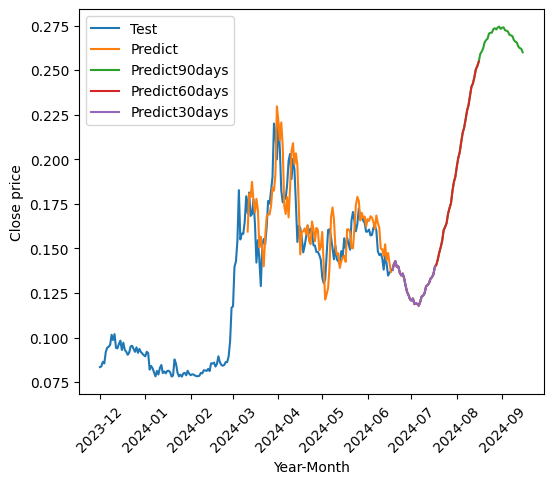

In [128]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Create the figure

# Assuming 'df' has a 'Date' column and 'train_size' is defined
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df['Date'][train_size+101:], y_pred, label='Predict')

# Generate future dates for predictions
predict_data_index_90 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=90, freq='D'
)
predict_data_index_60 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=60, freq='D'
)
predict_data_index_30 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=30, freq='D'
)

# Plot predictions (assuming lst_output_90, lst_output_60, lst_output_30 are predictions)
plt.plot(predict_data_index_90, scaler.inverse_transform(lst_output_90), label='Predict90days')
plt.plot(predict_data_index_60, scaler.inverse_transform(lst_output_60), label='Predict60days')
plt.plot(predict_data_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Year-Month')
plt.ylabel('Close price')
plt.legend()  # Use legend() to automatically generate labels from label arguments in plot

plt.show()


DOGE

In [129]:
# Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
# Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/DataBA/DOGE.csv')
df1=df.reset_index()['Close']


In [131]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [132]:
# Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [133]:
# Hàm  Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [134]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [135]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [136]:
# Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [137]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
27/27 [==============================] - 2s 21ms/step - loss: 0.0292
Epoch 2/100
27/27 [==============================] - 1s 21ms/step - loss: 0.0036
Epoch 3/100
27/27 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 4/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 6/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 7/100
27/27 [==============================] - 1s 21ms/step - loss: 0.0016
Epoch 8/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0015
Epoch 9/100
27/27 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 10/100
27/27 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 11/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0012
Epoch 12/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 13/100
27/27 [=====

In [138]:
# Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 8ms/step


In [139]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [140]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
import math
from sklearn.metrics import mean_squared_error

# Hàm tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm tính MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính MASE
def mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính sai số tuyệt đối trung bình của mô hình
    mae = np.mean(np.abs(y_true - y_pred))

    # Tính sai số tuyệt đối trung bình của phương pháp đơn giản (naive forecast)
    naive_forecast_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))

    if naive_forecast_error == 0:
        return np.inf
    else:
        return mae / naive_forecast_error

rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)
mase_value = mase(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_value)
print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Scaled Error (MASE):", mase_value)

Root Mean Squared Error (RMSE): 3392.6170896876483
Mean Absolute Percentage Error (MAPE): 484252.5985817143
Mean Absolute Scaled Error (MASE): 192893.84161513826


In [141]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.7428685]
101
1 day input [0.80402215 0.84177966 0.82265795 0.83010058 0.80302353 0.77308188
 0.727115   0.75493004 0.72630459 0.65032214 0.72337214 0.72050724
 0.6834889  0.68977513 0.7118487  0.73968127 0.74047738 0.72227239
 0.7344512  0.72457861 0.72428995 0.75281667 0.72271125 0.67347893
 0.68231592 0.68447216 0.68334106 0.69163459 0.71218158 0.76254945
 0.72239682 0.73030996 0.72377198 0.66617039 0.61935557 0.64722799
 0.63643426 0.63226919 0.61141791 0.62837904 0.62839624 0.64737889
 0.64638217 0.657701   0.66147406 0.64460433 0.64819835 0.6431355
 0.67068902 0.67092696 0.66112837 0.61958818 0.6096219  0.61338282
 0.63732875 0.640266   0.64510949 0.62917897 0.61817675 0.61000992
 0.62298969 0.59610272 0.59670897 0.60147917 0.60398778 0.59000105
 0.62233387 0.6028485  0.63466745 0.64062465 0.63057171 0.75311907
 0.78045562 0.77121556 0.77600574 0.7688786  0.77261288 0.78447045
 0.79728933 0.78843968 0.77541949 0.77246536 0.7743046  0.78071043
 0.77695776 0.77512359 0.78304475 0

In [142]:
# Dự báo 60 ngày tiếp theo

x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.7428685]
101
1 day input [0.80402215 0.84177966 0.82265795 0.83010058 0.80302353 0.77308188
 0.727115   0.75493004 0.72630459 0.65032214 0.72337214 0.72050724
 0.6834889  0.68977513 0.7118487  0.73968127 0.74047738 0.72227239
 0.7344512  0.72457861 0.72428995 0.75281667 0.72271125 0.67347893
 0.68231592 0.68447216 0.68334106 0.69163459 0.71218158 0.76254945
 0.72239682 0.73030996 0.72377198 0.66617039 0.61935557 0.64722799
 0.63643426 0.63226919 0.61141791 0.62837904 0.62839624 0.64737889
 0.64638217 0.657701   0.66147406 0.64460433 0.64819835 0.6431355
 0.67068902 0.67092696 0.66112837 0.61958818 0.6096219  0.61338282
 0.63732875 0.640266   0.64510949 0.62917897 0.61817675 0.61000992
 0.62298969 0.59610272 0.59670897 0.60147917 0.60398778 0.59000105
 0.62233387 0.6028485  0.63466745 0.64062465 0.63057171 0.75311907
 0.78045562 0.77121556 0.77600574 0.7688786  0.77261288 0.78447045
 0.79728933 0.78843968 0.77541949 0.77246536 0.7743046  0.78071043
 0.77695776 0.77512359 0.78304475 0

In [143]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1



[0.7428685]
101
1 day input [0.80402215 0.84177966 0.82265795 0.83010058 0.80302353 0.77308188
 0.727115   0.75493004 0.72630459 0.65032214 0.72337214 0.72050724
 0.6834889  0.68977513 0.7118487  0.73968127 0.74047738 0.72227239
 0.7344512  0.72457861 0.72428995 0.75281667 0.72271125 0.67347893
 0.68231592 0.68447216 0.68334106 0.69163459 0.71218158 0.76254945
 0.72239682 0.73030996 0.72377198 0.66617039 0.61935557 0.64722799
 0.63643426 0.63226919 0.61141791 0.62837904 0.62839624 0.64737889
 0.64638217 0.657701   0.66147406 0.64460433 0.64819835 0.6431355
 0.67068902 0.67092696 0.66112837 0.61958818 0.6096219  0.61338282
 0.63732875 0.640266   0.64510949 0.62917897 0.61817675 0.61000992
 0.62298969 0.59610272 0.59670897 0.60147917 0.60398778 0.59000105
 0.62233387 0.6028485  0.63466745 0.64062465 0.63057171 0.75311907
 0.78045562 0.77121556 0.77600574 0.7688786  0.77261288 0.78447045
 0.79728933 0.78843968 0.77541949 0.77246536 0.7743046  0.78071043
 0.77695776 0.77512359 0.78304475 0

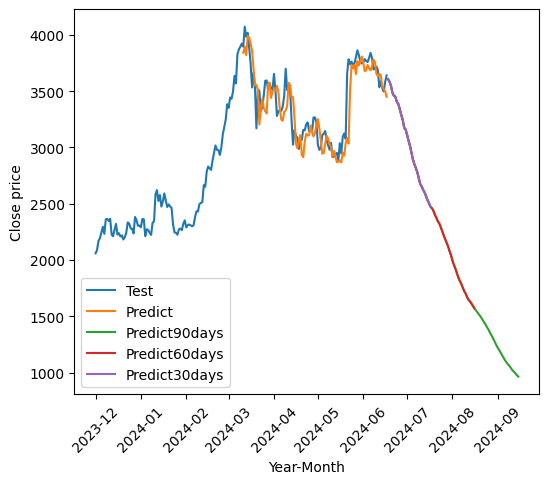

In [144]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Create the figure

# Assuming 'df' has a 'Date' column and 'train_size' is defined
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df['Date'][train_size+101:], y_pred, label='Predict')

# Generate future dates for predictions
predict_data_index_90 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=90, freq='D'
)
predict_data_index_60 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=60, freq='D'
)
predict_data_index_30 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=30, freq='D'
)

# Plot predictions (assuming lst_output_90, lst_output_60, lst_output_30 are predictions)
plt.plot(predict_data_index_90, scaler.inverse_transform(lst_output_90), label='Predict90days')
plt.plot(predict_data_index_60, scaler.inverse_transform(lst_output_60), label='Predict60days')
plt.plot(predict_data_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Year-Month')
plt.ylabel('Close price')
plt.legend()  # Use legend() to automatically generate labels from label arguments in plot

plt.show()
